In [1]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'syn_weight_dist_201228_diameter_count'


sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

from weight_database import WeightDatabase
weightdb = WeightDatabase()

def weight_fn(syn):
    z_len = syn['z_length'] - 40
    major_axis_length = syn['major_axis_length'] * .9
    diameter = max(z_len, major_axis_length)
    diameter = int(diameter/40+.5)
    diameter *= 40
    return diameter

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pfs/gen_201224_setup01_syndb_threshold_10_coalesced.gz',
    weight_fn=weight_fn)

mpd = MyPlotData()
mpd_raw = MyPlotData()
hist = defaultdict(int)
weights_db = weightdb.get_weights()
n_synapses = 0
raw_data = []
raw_data_area = []

for neuron, pc_weights in weights_db.items():
    # print(n)
    for pc, weights in pc_weights.items():
        for w in weights:
            w /= 1000
            hist[w] += 1
            n_synapses += 1
            raw_data.append(w)
            area = w*w/4*3.14
            raw_data_area.append(area)
            mpd_raw.add_data_point(
                cleft_area=w,
                type='Observed')

# print(hist)
for k in sorted([k for k in hist.keys()]):
#     print(f'{k}: {hist[k]}')
    mpd.add_data_point(
        count=hist[k],
        cleft_area=k)

print(f'n={n_synapses} synapses')


n=26153 synapses


Height: 4, Aspect: 1.33


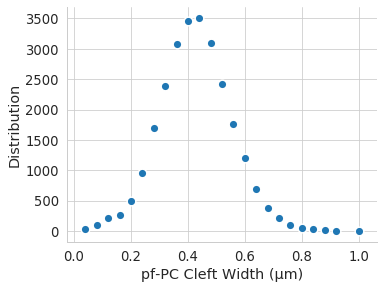

Height: 4, Aspect: 1.33


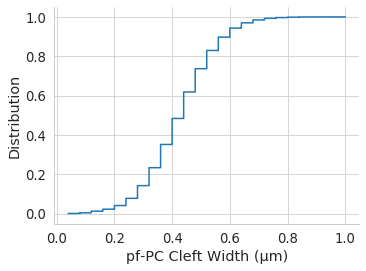

[0.02 0.06 0.1  0.14 0.18 0.22 0.26 0.3  0.34 0.38 0.42 0.46 0.5  0.54
 0.58 0.62 0.66 0.7  0.74 0.78 0.82 0.86 0.9  0.94 0.98 1.02]
Height: 4, Aspect: 1.33


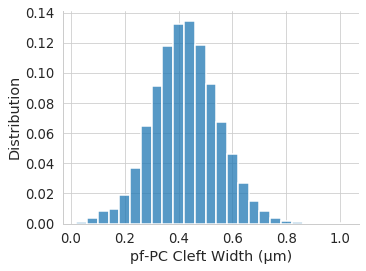

In [7]:

# mpd = mpd.to_pdf('count', cumulative=False)
mpd_cdf = mpd.to_pdf('count', cumulative=False)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd,
    x="cleft_area",
    y="count",
    # xlim=[None, .6],
    s=75,
    kind='scatter',
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='pf-PC Cleft Width (µm)',
    show=True,
    save_filename=f'{script_n}_scatter.svg',
    )

importlib.reload(my_plot); my_plot.my_displot(
    mpd_raw,
    x="cleft_area",
    # y="count",
    # xlim=[None, .6],
    # s=100,
    kind='ecdf',
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='pf-PC Cleft Width (µm)',
    show=True,
    save_filename=f'{script_n}_ecdf.svg',
    )


df = mpd_raw.to_dataframe()
width = .04
bins = np.linspace(df["cleft_area"].min() - width/2, df["cleft_area"].max() + width/2, int(df["cleft_area"].max()/width)+1)
print(bins)
# df["A"].hist(bins=bins)

importlib.reload(my_plot); my_plot.my_displot(
    mpd_raw,
    x="cleft_area",
    # y="count",
    # xlim=[None, .6],
    # s=100,
    kind='hist',
    # binwidth=.0399,
    bins=bins,
    stat='probability',
#     kde=True,
#     kde_kws={'bw_adjust': 3.5},
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='pf-PC Cleft Width (µm)',
    show=True,
    save_filename=f'{script_n}_hist.svg',
    )



In [3]:
# calculate coefficient of variation
from scipy.stats import variation
cov = variation(raw_data)
print(f'Coefficient of variation for GrC-PC synapse width: {cov}')

Coefficient of variation for GrC-PC synapse width: 0.28653083034955157


In [2]:
# calculate coefficient of variation
from scipy.stats import variation
cov = variation(raw_data_area)
print(f'Coefficient of variation for GrC-PC synapse area: {cov}')

Coefficient of variation for GrC-PC synapse area: 0.5472710136860437


Height: 4, Aspect: 1.33


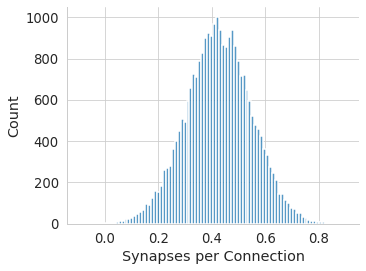

In [17]:
# fit lognormal
from scipy.stats import norm

loc, scale = norm.fit(raw_data)
r = norm.rvs(loc=loc, scale=scale, size=len(raw_data))

mpd_fit = MyPlotData()
for v in r:
    mpd_fit.add_data_point(
        cleft_area=v,
        type='Fit')

importlib.reload(my_plot); my_plot.my_displot(
    mpd_fit,
    x="cleft_area",
    # y="count",
#     xlim=[None, 50],
    # xlim=[-1.5, None],
    # s=100,
    kind='hist',
#     discrete=True,
    # log_scale_x=True,
    # binwidth=.0399,
    # kde=True,
    # kde_kws={'bw_adjust': 3.5},
    context='paper',
    height=4,
    y_axis_label='Count',
    x_axis_label='Synapses per Connection',
    show=True,
    save_filename=f'{script_n}_hist_fit2.svg',
    )

Height: 4, Aspect: 1.33


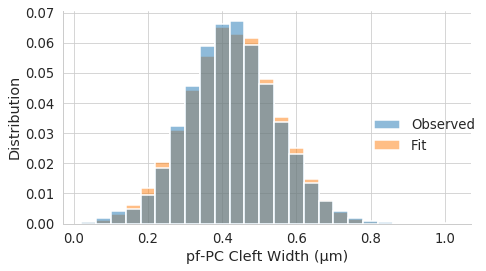

In [22]:
mpd_all = MyPlotData()
mpd_all.append(mpd_raw)
mpd_all.append(mpd_fit)
importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    x="cleft_area",
    # y="count",
    # xlim=[None, .6],
    # s=100,
    kind='hist',
    hue='type',
    # binwidth=.0399,
    bins=bins,
    stat='probability',
#     kde=True,
#     kde_kws={'bw_adjust': 3.5},
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='pf-PC Cleft Width (µm)',
    show=True,
    save_filename=f'{script_n}_hist_fit.svg',
    )